# Synthetic Cuneiform Sentence Generator

This notebook generates a large dataset of synthetic Sumerian cuneiform sentences for training object detection models. It performs the following operations:

1. **Creates realistic cuneiform text lines** by randomly placing individual glyph characters on horizontal canvases
2. **Applies transformations** to each glyph, including contrast reduction, Gaussian blur, rotation, and scaling
3. **Adds background effects** which can resamble artifact pictures through background noise and random masking patterns that simulate damaged clay tablets
4. **Generates YOLO-compatible annotations** with precise bounding boxes for each glyph in normalized coordinates
5. **Organizes the dataset** into proper training and validation splits following the YOLO format requirements

The generated dataset serves as the foundation for training object detection models that can identify and classify individual cuneiform characters in tablet images. This synthetic data generation approach allows us to create a large, perfectly-labeled dataset that would be impractical to produce through manual annotation.

This data preparation step is crucial for developing a robust Sumerian glyph detection system capable of working with actual archaeological artifacts, providing a stepping stone between isolated character recognition and full tablet transcription.

In [1]:
import os
import random
import numpy as np

from PIL import Image, ImageEnhance, ImageFilter, ImageDraw
import matplotlib.pyplot as plt

In [2]:
# === CONFIG ===
INPUT_DIR = "glyph_images"
YOLO_DATA_DIR = "yolo_dataset"
CANVAS_SIZE = (1500, 300)
GLYPHS_PER_SENTENCE = 10
NUM_SENTENCES = 100000
TRAIN_RATIO = 0.8  # 80% for training, 20% for validation

# === PREPARE FOLDERS ===
for split in ["train", "val"]:
    os.makedirs(os.path.join(YOLO_DATA_DIR, "images", split), exist_ok=True)
    os.makedirs(os.path.join(YOLO_DATA_DIR, "labels", split), exist_ok=True)

# === LOAD GLYPHS ===
# Assuming this part is in a cell after INPUT_DIR is defined
glyph_files = sorted([f for f in os.listdir(INPUT_DIR) if f.endswith(('.png', '.jpg', '.jpeg'))])
glyph_classes = {f: idx for idx, f in enumerate(glyph_files)}
num_classes = len(glyph_classes)
print(f"Detected {num_classes} glyph classes.")

Detected 922 glyph classes.


In [3]:
# === UTILITY: Add background noise ===
def add_background_noise(image, intensity=8):
    noise = np.random.randint(0, intensity, (image.height, image.width), dtype='uint8')
    img_np = np.array(image).astype(np.int16)
    noisy_image = img_np + noise
    noisy_image = np.clip(noisy_image, 0, 255).astype('uint8')
    return Image.fromarray(noisy_image)

# === UTILITY: Add smaller, sparser grey masking rectangles ===
def add_grey_mask(image):
    draw = ImageDraw.Draw(image)
    num_masks = random.randint(60, 80)
    for _ in range(num_masks):
        w = random.randint(image.width // 60, image.width // 40)  # range instead of fixed
        h = random.randint(image.height // 60, image.height // 40)
        x0 = random.randint(0, max(image.width - w, 0))
        y0 = random.randint(0, max(image.height - h, 0))
        x1 = x0 + w
        y1 = y0 + h
        shade = random.randint(100, 200)
        draw.rectangle([x0, y0, x1, y1], fill=shade)
    return image

# === UTILITY: Add random stretch to glyphs ===
def apply_random_stretch(glyph, stretch_prob=0.7):
    # Only apply stretching sometimes based on probability
    if random.random() > stretch_prob:
        return glyph
        
    # Get original size
    orig_width, orig_height = glyph.size
    
    # Calculate stretch factors
    # More horizontal than vertical stretching is common in cuneiform tablets
    stretch_x = random.uniform(0.85, 1.20)  # Horizontal stretch factor
    stretch_y = random.uniform(0.90, 1.15)  # Vertical stretch factor
    
    # Calculate new dimensions
    new_width = int(orig_width * stretch_x)
    new_height = int(orig_height * stretch_y)
    
    # Apply stretching through resize
    stretched_glyph = glyph.resize((new_width, new_height), resample=Image.BILINEAR)
    
    return stretched_glyph

# === GENERATE SYNTHETIC SENTENCES ===
count = 0
for i in range(NUM_SENTENCES):
    if count % 500 == 0:
        print(f"Generating sentence {i}/{NUM_SENTENCES}...")
    count += 1

    # Choose the split (train/val) based on the ratio
    if i < NUM_SENTENCES * TRAIN_RATIO:
        split = "train"
    else:
        split = "val"

    canvas = Image.new('L', CANVAS_SIZE, color=255)
    x_offset = 5
    bboxes = []

    for glyph_name in random.sample(glyph_files, GLYPHS_PER_SENTENCE):

        class_id = glyph_classes[glyph_name]
        glyph_path = os.path.join(INPUT_DIR, glyph_name)
        glyph = Image.open(glyph_path).convert('L')

        # Contrast reduction and blur
        glyph = ImageEnhance.Contrast(glyph).enhance(random.uniform(0.5, 0.9))
        glyph = glyph.filter(ImageFilter.GaussianBlur(radius=random.uniform(0.5, 1.5)))

        # Rotation
        angle = random.uniform(-10, 10)
        glyph = glyph.rotate(angle, expand=True, fillcolor=255)

        # Crop non-white regions
        glyph_np = np.array(glyph)
        mask = glyph_np < 250
        if not np.any(mask):
            continue
        coords = np.argwhere(mask)
        y0, x0 = coords.min(axis=0)
        y1, x1 = coords.max(axis=0) + 1
        cropped = glyph.crop((x0, y0, x1, y1))

        # Resize with scale factor
        max_height = CANVAS_SIZE[1] - 10
        scale = random.uniform(0.8, 1.2)
        if cropped.height > max_height:
            scale *= max_height / cropped.height
        new_size = (int(cropped.width * scale), int(cropped.height * scale))
        cropped = cropped.resize(new_size, resample=Image.BILINEAR)

        # Check horizontal space
        if x_offset + cropped.width > CANVAS_SIZE[0]:
            break  # Stop placing glyphs if it doesn't fit

        # Vertical jitter
        y_jitter = random.randint(-3, 3)
        y_offset = (CANVAS_SIZE[1] - cropped.height) // 2 + y_jitter

        # Paste glyph
        canvas.paste(cropped, (x_offset, y_offset))

        # Bounding box (normalized coords) - clamp to [0,1]
        bbox_x_center = (x_offset + cropped.width / 2) / CANVAS_SIZE[0]
        bbox_y_center = (y_offset + cropped.height / 2) / CANVAS_SIZE[1]
        bbox_width = cropped.width / CANVAS_SIZE[0]
        bbox_height = cropped.height / CANVAS_SIZE[1]

        # Clamp bbox values to [0,1] to avoid out-of-bounds errors
        bbox_x_center = min(max(bbox_x_center, 0), 1)
        bbox_y_center = min(max(bbox_y_center, 0), 1)
        bbox_width = min(max(bbox_width, 0), 1)
        bbox_height = min(max(bbox_height, 0), 1)

        bboxes.append((class_id, bbox_x_center, bbox_y_center, bbox_width, bbox_height))

        # Update x_offset with positive increment
        x_offset += cropped.width + random.randint(10, 15)

    # Add visual effects
    canvas = add_grey_mask(canvas)
    canvas = add_background_noise(canvas, intensity=8)
    canvas = apply_random_stretch(canvas, stretch_prob=0.7)

    # Save image and label
    img_path = os.path.join(YOLO_DATA_DIR, "images", split, f"sentence_{i}.png")
    canvas.convert("RGB").save(img_path)

    label_path = os.path.join(YOLO_DATA_DIR, "labels", split, f"sentence_{i}.txt")
    with open(label_path, 'w') as f:
        for bbox in bboxes:
            f.write(f"{bbox[0]} {bbox[1]:.6f} {bbox[2]:.6f} {bbox[3]:.6f} {bbox[4]:.6f}\n")

print("✅ Synthetic sentences generated with glyph bounds checking and splitted into train/val sets.")

Generating sentence 0/100000...
Generating sentence 500/100000...
Generating sentence 1000/100000...
Generating sentence 1500/100000...
Generating sentence 2000/100000...
Generating sentence 2500/100000...
Generating sentence 3000/100000...
Generating sentence 3500/100000...
Generating sentence 4000/100000...
Generating sentence 4500/100000...
Generating sentence 5000/100000...
Generating sentence 5500/100000...
Generating sentence 6000/100000...
Generating sentence 6500/100000...
Generating sentence 7000/100000...
Generating sentence 7500/100000...
Generating sentence 8000/100000...
Generating sentence 8500/100000...
Generating sentence 9000/100000...
Generating sentence 9500/100000...
Generating sentence 10000/100000...
Generating sentence 10500/100000...
Generating sentence 11000/100000...
Generating sentence 11500/100000...
Generating sentence 12000/100000...
Generating sentence 12500/100000...
Generating sentence 13000/100000...
Generating sentence 13500/100000...
Generating sente

In [6]:
import os

YOLO_DATA_DIR = "yolo_dataset"

# count elements
def count_elements_in_dir(directory):
    count = 0
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith(('.png', '.jpg', '.jpeg', '.txt')):
                count += 1
    return count
# count images and labels
print('training images:', count_elements_in_dir(os.path.join(YOLO_DATA_DIR, "images/train")))
print('training images:', count_elements_in_dir(os.path.join(YOLO_DATA_DIR, "labels/train")))

print('validation images:', count_elements_in_dir(os.path.join(YOLO_DATA_DIR, "images/val")))
print('validation images:', count_elements_in_dir(os.path.join(YOLO_DATA_DIR, "labels/val")))

training images: 80000
training images: 80000
validation images: 20000
validation images: 20000


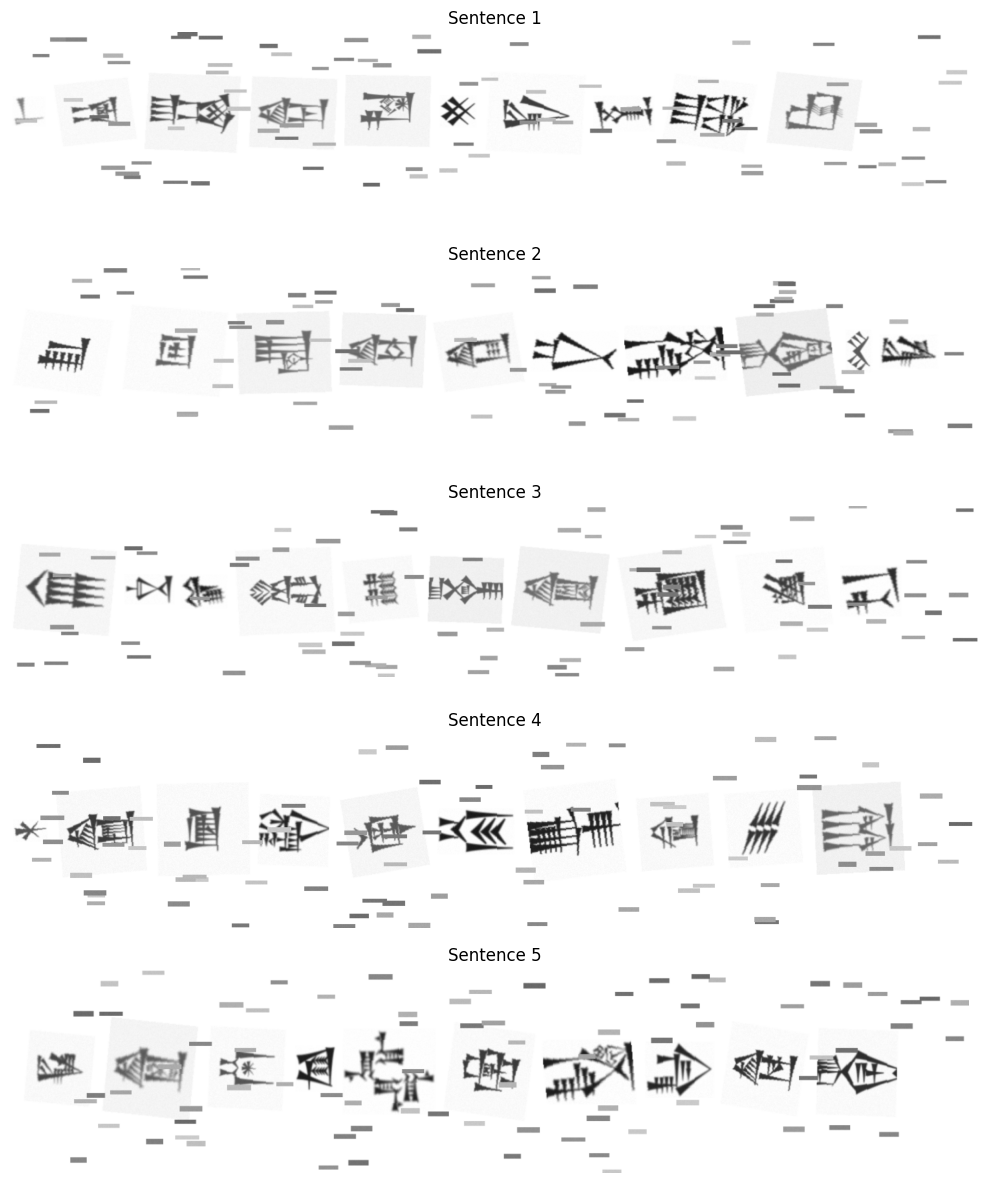

In [7]:
# plot more images one below the other
fig, axs = plt.subplots(5, 1, figsize=(10, 12))

for i in range(1, 6):
    img_path = os.path.join(YOLO_DATA_DIR, "images", "train", f"sentence_{i}.png")
    img = Image.open(img_path)
    axs[i-1].imshow(img)
    axs[i-1].axis('off')
    axs[i-1].set_title(f"Sentence {i}")

plt.tight_layout()
plt.show()